# FWI Example with wavefield separation
This notebook explores performing up/down wavefield separation on source and receiver wavefields prior to correlation for a transmission experiment. We use a simple Kz wavenumber filter, zeroing negative or positive spatial frequencies in depth `z`. We then correlate source up with receiver up, and source down with receiver down.

We will contrast the wavefield separation FWI operator with the standard FWI operator. 

We will peform FWI using the following steps:
1. Prepare models
2. Build a small local compute cluster (2 workers) 
3. Create list of shot locations 
4. Build `F`, the distributed block operator for seismic modeling
5. Use `F` to create data for both models
6. Visualize data
7. Assess if data is cycle skipped at the farthest offsets
8. Build the `gradient!` and `cost` functions
9. Perform the FWI using `Optim.jl`
10. Visualize velocity models and objection function
11. Visualize data match 
12. Write models to local disk
13. Remove local files and workers

#### Note on runtime
Warning: this notebook takes more than 1 hour to run for 12 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages
Uncomment the line below if you need to add these packages to your environment

In [1]:
# ]add Optim LineSearches

## Record time for start of notebook

In [2]:
time_beg = time()

1.603801712345081e9

In [3]:
using PyPlot, Distributed, Jets, JetPack, JetPackDSP, Printf

## 1. Prepare models
* Initial model is a wholespace
* True model is the initial model with a rectangular inclusion

In [4]:
dz,dx = 25,25
nz,nx = 251,251

v1 = 1500 .* ones(Float32,nz,nx);
v2 = 1500 .* ones(Float32,nz,nx);

w = 20
v1[div(nz,2)-w:div(nz,2)+w,div(nx,2)-w:div(nx,2)+w] .+= 200;

#### Visualize

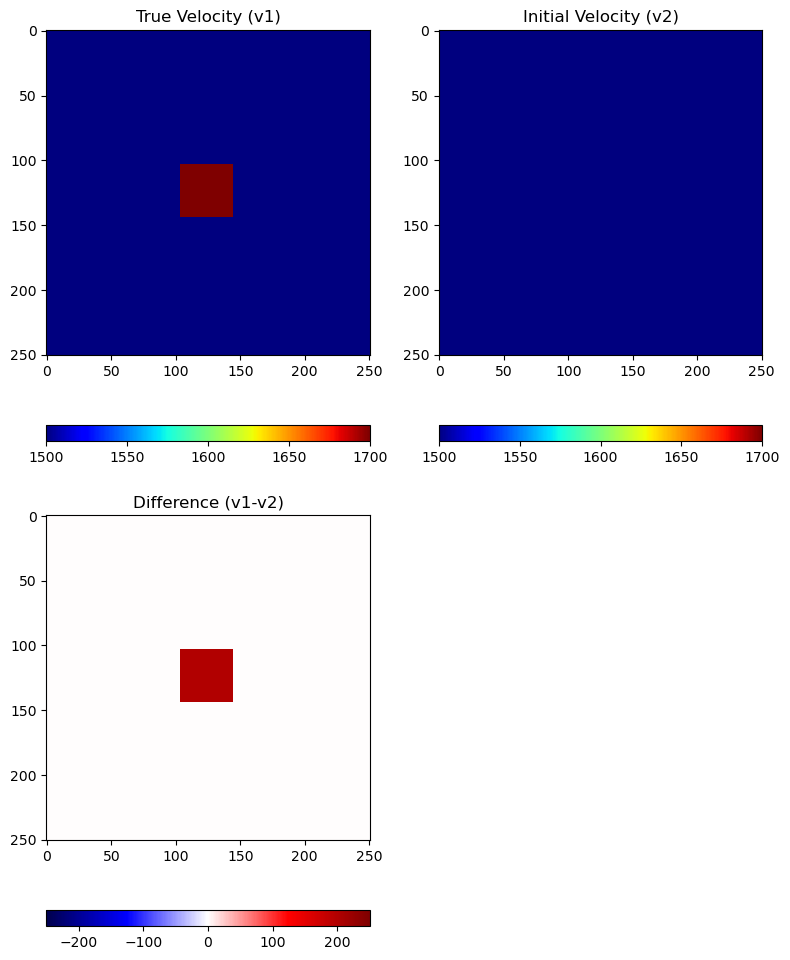

In [5]:
figure(figsize=(8,10))
vmin,vmax = extrema(v1)
dmin,dmax = -250,250

subplot(2,2,1); imshow(v1,aspect="auto",cmap="jet", interpolation="nearest"); 
colorbar(orientation="horizontal"); clim(vmin,vmax); title("True Velocity (v1)")

subplot(2,2,2); imshow(v2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax); title("Initial Velocity (v2)");

subplot(2,2,3); imshow(v1.-v2,aspect="auto",cmap="seismic", interpolation="nearest");
colorbar(orientation="horizontal"); clim(dmin,dmax); title("Difference (v1-v2)");

tight_layout()

## 2. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [6]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [7]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 3. Create list of shot locations 
We use 12 shot locations evenly in depth along the left edge of the model.

In [8]:
nshots = 12
sz = round.(Int,collect(range(0,stop=(nz-1)*dz,length=nshots)))
@show nshots;
@show sz;

nshots = 12
sz = [0, 568, 1136, 1705, 2273, 2841, 3409, 3977, 4545, 5114, 5682, 6250]


## 4. Build `F1` and `F2`, the distributed block operators for seismic modeling
* `F1` is the standard operator
* `F2` is the operator with wavefield separation via Kz wavenumber filter

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [9]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [10]:
@everywhere begin
    ntrec = 2001
    dtrec = 0.004
    dtmod = 0.002
end

@everywhere function makeF(i,nz,nx,dz,dx,sz; imgcondition="standard")
    @show imgcondition
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sz = sz[i],
        sx = dx,
        rz = dz * [0:1:nz-1;],
        rx = dx * (nx - 1) .* ones(nz),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        nsponge = 100,
        imgcondition = imgcondition,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=0)
end

In [11]:
F1 = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sz,imgcondition="standard") 
        for i in I[1], j in I[2]], (nshots,1))

F2 = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sz,imgcondition="FWI") 
        for i in I[1], j in I[2]], (nshots,1))

      From worker 2:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worke

"Jet nonlinear operator, (251, 251) → (6027012,)"

## 5. Use `F1` to create the data in both models

In [12]:
t1 = @elapsed begin
    d1 = F1*v1;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

t2 = @elapsed begin
    d2 = F1*v2;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in true model; 32.75 seconds
└ @ Main In[12]:4
┌ Info: Time in init model; 21.66 seconds
└ @ Main In[12]:9


#### Compute the residual data

In [13]:
r = d1 .- d2;

## 6. Visualize data

#### Collect 3 shots locally before plotting

In [14]:
shots = [1,6,12]
szlocal = [sz[i] for i in shots]
@show shots
@show szlocal;

d1local = [getblock(d1,i) for i in shots];
d2local = [getblock(d2,i) for i in shots];
rlocal = [getblock(r,i) for i in shots];

shots = [1, 6, 12]
szlocal = [0, 2841, 6250]


#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data</b></td>
</tr>
</table>

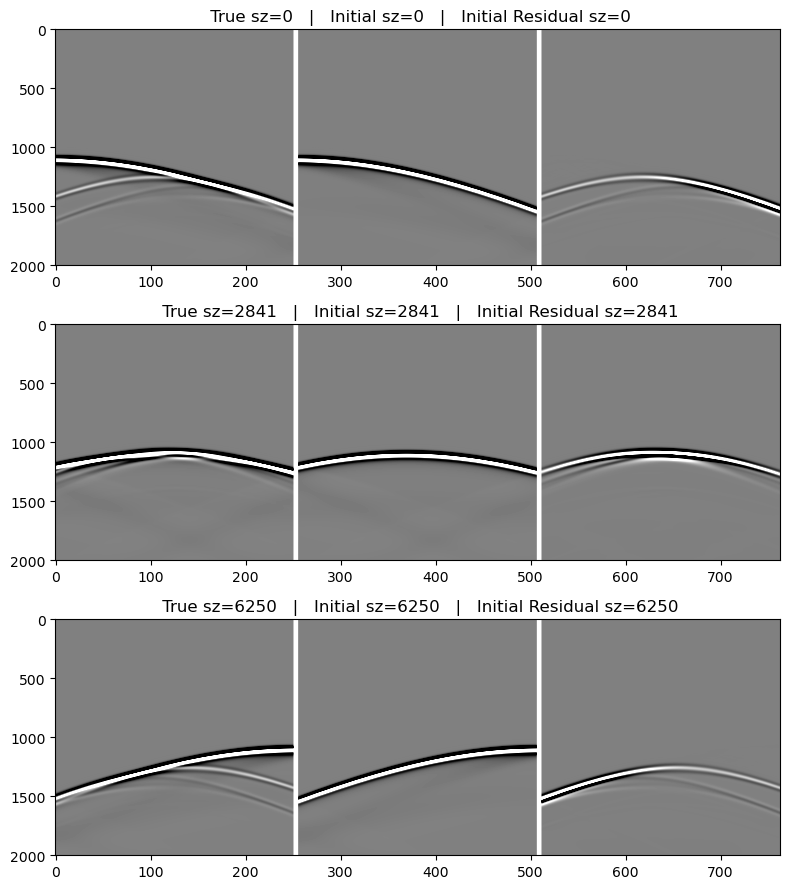

scale = 17.554220204326107


In [15]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = hcat(d1local[iplot], pad, d2local[iplot], pad, rlocal[iplot])
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" True sz=$(sz[ishot])   |   Initial sz=$(sz[ishot])   |   Initial Residual sz=$(sz[ishot])");
end
tight_layout()

## 8. Build the `gradient!` and `cost` functions

#### Build the `gradient!` function
This method is called by the solver whenever the gradient is required. Note one difference for this transmission experiment relative the first FWI notebook is that we do not want to apply source side illumination compensation.

Steps in computing the gradient are as follows:
1. Apply box constraints to keep velocity inside `[vmin,vmax]`
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

We can use this function for both operators `F1` and `F2`, but we need to be careful about the `FwiPar` struct we use to save the maximum value of the first gradient. 

In [16]:
function gradient!(G,F,v,dobs,p)
    clamp!(v,vmin,vmax)
    J = jacobian(F,v)
    t = @elapsed begin
        dv = F*v
        G .= J' * (dv .- dobs)
    end
    ϕ = 0.5 * norm(dv .- dobs)^2
    p.countG += 1
    @printf("f=%3d g=%3d %10.4f sec -- |Fv-y| %10.4e -- |g| %10.4e\n", 
        p.countF, p.countG, t, ϕ, norm(G))
    flush(stdout)
    if p.gscale == 0.0
        # compute scalar from first gradient, apply to future gradients
        p.gscale = 10 ./ maximum(G)
        @show p.gscale
    end
    G .*= p.gscale
end
# struct to save the first gradient scalar
mutable struct FwiPar
   countF::Int64
   countG::Int64
   gscale::Float64
end

#### Compute gradients with and without wavefield separation and display

In [17]:
grad1 = zeros(Float32,size(v1))
grad2 = zeros(Float32,size(v1))

tgrad1 = @elapsed begin
    p1 = FwiPar(0,0,0.0)
    gradient!(grad1,F1,v2,d1,p1)
end
@show tgrad1;

tgrad2 = @elapsed begin
    p2 = FwiPar(0,0,0.0)
    gradient!(grad2,F2,v2,d1,p2)
end
@show tgrad2;

f=  0 g=  1    13.4221 sec -- |Fv-y| 5.8364e+05 -- |g| 9.5099e+01
p.gscale = 9.94798755645752
tgrad1 = 14.454500666
f=  0 g=  1    63.1357 sec -- |Fv-y| 5.8382e+05 -- |g| 4.3223e+01
p.gscale = 16.9777889251709
tgrad2 = 63.452253892


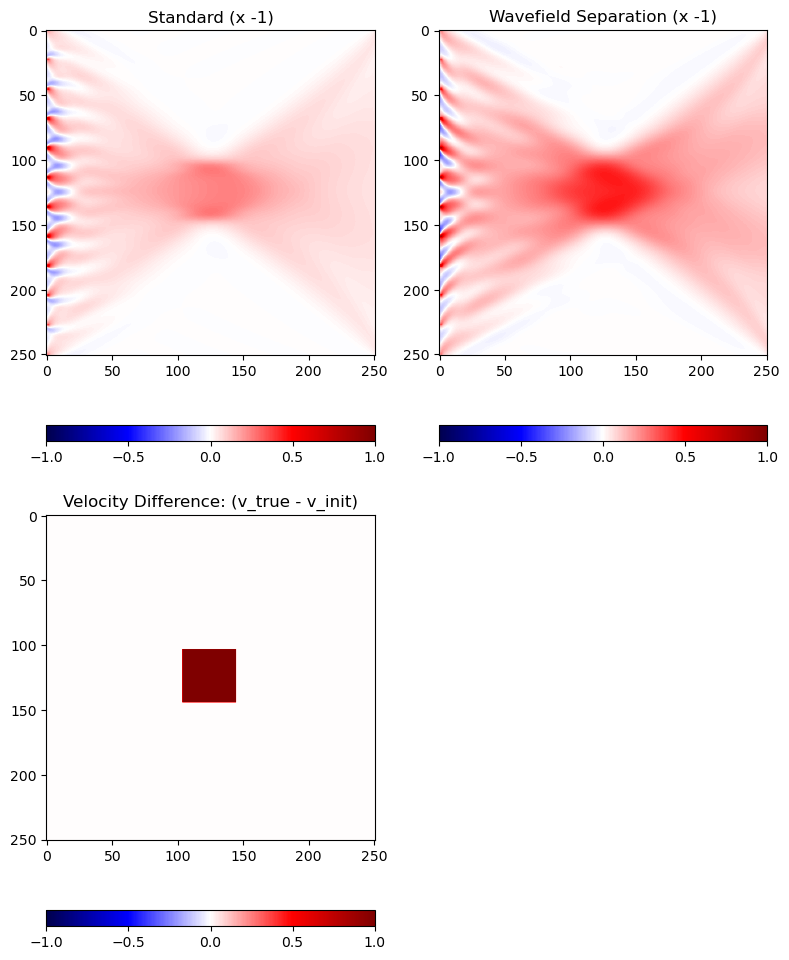

In [18]:
dv = v1 .- v2

figure(figsize=(8,10))

subplot(2,2,1)
imshow(-1 .* grad1 ./ maximum(abs,grad1),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Standard (x -1)");

subplot(2,2,2)
imshow(-1 .* grad2 ./ maximum(abs,grad2),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Wavefield Separation (x -1)");

subplot(2,2,3)
imshow(dv ./ maximum(abs,dv),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Velocity Difference: (v_true - v_init)");

tight_layout()

#### Build the `cost` function
Note we also need to apply box constraints here to keep the model in the range `[vmin,vmax]`.

In [19]:
function cost(x,F,d1,p)
    clamp!(x,vmin,vmax)
    t = @elapsed begin
        dx = F*x
    end
    ϕ = 0.5 * norm(d1 .- dx)^2
    p.countF += 1
    @printf("f=%3d g=%3d %10.4f sec -- |Fv-y| %10.4e\n", p.countF, p.countG, t, ϕ)
    flush(stdout)
    return ϕ
end

cost (generic function with 1 method)

In [20]:
p1 = FwiPar(0,0,0.0)
@show cost(v2,F1,d1,p1)
p2 = FwiPar(0,0,0.0)
@show cost(v2,F2,d1,p2)

f=  1 g=  0     0.6004 sec -- |Fv-y| 5.8364e+05
cost(v2, F1, d1, p1) = 583636.3125
f=  1 g=  0     0.6045 sec -- |Fv-y| 5.8364e+05
cost(v2, F2, d1, p2) = 583636.3125


583636.3125

## 9. Perform the FWI using `Optim.jl`
We will do 10 iterations of limited memory BFGS for each operator. 

In [21]:
niter = 15

15

In [22]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    flush(stdout)
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

#### Optimization with the standard operator

In [23]:
topt1 = @elapsed begin
    p1 = FwiPar(0,0,0.0)
    f(x) = cost(x,F1,d1,p1)
    g!(G,x) = gradient!(G,F1,x,d1,p1)

    solver1 = LBFGS(m = niter, 
        alphaguess = LineSearches.InitialStatic(), 
        linesearch = LineSearches.BackTracking(order=3));

    result1 = optimize(f, g!, v2, solver1,
        Optim.Options(
            iterations = niter,
            show_trace = false,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback))
end;

f=  0 g=  1    10.7057 sec -- |Fv-y| 5.8364e+05 -- |g| 9.5099e+01
p.gscale = 9.94798755645752
f=  1 g=  1     0.5994 sec -- |Fv-y| 5.8364e+05


┌ Info: iter=0, cost=583636.3, |grad|=47.17163
└ @ Main In[22]:2


f=  2 g=  1    25.9161 sec -- |Fv-y| 4.2488e+05
f=  2 g=  2    10.6708 sec -- |Fv-y| 4.2473e+05 -- |g| 8.5233e+01


┌ Info: iter=1, cost=424883.44, |grad|=29.280508
└ @ Main In[22]:2


f=  3 g=  2    25.9132 sec -- |Fv-y| 1.2353e+06
f=  4 g=  2    26.9428 sec -- |Fv-y| 3.3835e+05
f=  4 g=  3    38.7092 sec -- |Fv-y| 3.3835e+05 -- |g| 1.3545e+02
f=  5 g=  3     0.6724 sec -- |Fv-y| 3.3817e+05


┌ Info: iter=2, cost=338167.84, |grad|=32.50787
└ @ Main In[22]:2


f=  6 g=  3    28.0368 sec -- |Fv-y| 1.7984e+05
f=  6 g=  4    12.8404 sec -- |Fv-y| 1.7977e+05 -- |g| 7.7322e+01


┌ Info: iter=3, cost=179841.2, |grad|=17.677677
└ @ Main In[22]:2


f=  7 g=  4    28.6711 sec -- |Fv-y| 1.2556e+05
f=  7 g=  5    12.8094 sec -- |Fv-y| 1.2554e+05 -- |g| 5.5968e+01


┌ Info: iter=4, cost=125557.98, |grad|=11.259559
└ @ Main In[22]:2


f=  8 g=  5    29.2429 sec -- |Fv-y| 6.6045e+04
f=  8 g=  6    13.3651 sec -- |Fv-y| 6.6068e+04 -- |g| 5.0532e+01


┌ Info: iter=5, cost=66044.664, |grad|=11.3279505
└ @ Main In[22]:2


f=  9 g=  6    30.2293 sec -- |Fv-y| 2.2462e+05
f= 10 g=  6    30.5171 sec -- |Fv-y| 9.9827e+04
f= 11 g=  6    30.7271 sec -- |Fv-y| 5.9991e+04
f= 11 g=  7    42.9310 sec -- |Fv-y| 5.9991e+04 -- |g| 5.7583e+01
f= 12 g=  7     0.6681 sec -- |Fv-y| 6.0005e+04


┌ Info: iter=6, cost=60005.348, |grad|=12.204768
└ @ Main In[22]:2


f= 13 g=  7    30.6082 sec -- |Fv-y| 3.8268e+05
f= 14 g=  7    30.5857 sec -- |Fv-y| 3.3161e+05
f= 15 g=  7    30.7407 sec -- |Fv-y| 2.5767e+05
f= 16 g=  7    30.8315 sec -- |Fv-y| 1.5875e+05
f= 17 g=  7    30.8258 sec -- |Fv-y| 8.5335e+04
f= 18 g=  7    31.0520 sec -- |Fv-y| 6.5885e+04
f= 19 g=  7    31.5752 sec -- |Fv-y| 6.1507e+04
f= 20 g=  7    31.1948 sec -- |Fv-y| 6.0453e+04
f= 21 g=  7    31.8148 sec -- |Fv-y| 6.0155e+04
f= 22 g=  7    30.7785 sec -- |Fv-y| 6.0056e+04
f= 23 g=  7    31.5955 sec -- |Fv-y| 6.0018e+04
f= 24 g=  7    31.1565 sec -- |Fv-y| 6.0003e+04
f= 24 g=  8    14.2164 sec -- |Fv-y| 6.0016e+04 -- |g| 5.7604e+01
f= 25 g=  8     0.6653 sec -- |Fv-y| 6.0016e+04


┌ Info: iter=7, cost=60016.12, |grad|=12.211644
└ @ Main In[22]:2


In [24]:
@info @printf("Time for optimization (standard); %.2f minutes\n", topt1 / 60)
@info "result1=\n$result1\n"

Time for optimization (standard); 13.17 minutes


┌ Info: nothing
└ @ Main In[24]:1
┌ Info: result1=
│  * Status: failure (objective increased between iterations)
│ 
│  * Candidate solution
│     Final objective value:     6.000535e+04
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 1.44e-01 ≰ 0.0e+00
│     |x - x'|/|x'|          = 8.44e-05 ≰ 0.0e+00
│     |f(x) - f(x')|         = 1.08e+01 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 1.80e-04 ≰ 0.0e+00
│     |g(x)|                 = 1.22e+01 ≰ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   777  (vs limit Inf)
│     Iterations:    7
│     f(x) calls:    25
│     ∇f(x) calls:   8
│ 
└ @ Main In[24]:2


#### Optimization with the wavefield separation operator

In [25]:
topt2 = @elapsed begin
    p2 = FwiPar(0,0,0.0)
    f(x) = cost(x,F2,d1,p2)
    g!(G,x) = gradient!(G,F2,x,d1,p2)

    solver2 = LBFGS(m = niter, 
        alphaguess = LineSearches.InitialStatic(), 
        linesearch = LineSearches.BackTracking(order=3));

    result2 = optimize(f, g!, v2, solver2,
        Optim.Options(
            iterations = niter,
            show_trace = false,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback))
end;

f=  0 g=  1    40.7648 sec -- |Fv-y| 5.8364e+05 -- |g| 4.3229e+01
p.gscale = 16.98952865600586
f=  1 g=  1     0.6000 sec -- |Fv-y| 5.8364e+05


┌ Info: iter=0, cost=583636.3, |grad|=21.055712
└ @ Main In[22]:2


f=  2 g=  1    30.5861 sec -- |Fv-y| 4.6112e+05
f=  2 g=  2    40.9436 sec -- |Fv-y| 4.6095e+05 -- |g| 3.9171e+01


┌ Info: iter=1, cost=461120.97, |grad|=15.783362
└ @ Main In[22]:2


f=  3 g=  2    31.0906 sec -- |Fv-y| 1.4369e+06
f=  4 g=  2    30.9153 sec -- |Fv-y| 3.4037e+05
f=  4 g=  3    71.6594 sec -- |Fv-y| 3.4037e+05 -- |g| 6.4095e+01
f=  5 g=  3     0.6360 sec -- |Fv-y| 3.4015e+05


┌ Info: iter=2, cost=340153.4, |grad|=14.307614
└ @ Main In[22]:2


f=  6 g=  3    31.2348 sec -- |Fv-y| 2.0592e+05
f=  6 g=  4    41.1946 sec -- |Fv-y| 2.0579e+05 -- |g| 3.4376e+01


┌ Info: iter=3, cost=205916.8, |grad|=8.122071
└ @ Main In[22]:2


f=  7 g=  4    31.3728 sec -- |Fv-y| 1.5896e+05
f=  7 g=  5    41.1853 sec -- |Fv-y| 1.5887e+05 -- |g| 2.8396e+01


┌ Info: iter=4, cost=158959.4, |grad|=6.5879073
└ @ Main In[22]:2


f=  8 g=  5    31.4901 sec -- |Fv-y| 6.4881e+04
f=  8 g=  6    41.2521 sec -- |Fv-y| 6.4873e+04 -- |g| 2.7343e+01


┌ Info: iter=5, cost=64881.004, |grad|=6.0519056
└ @ Main In[22]:2


f=  9 g=  6    31.6501 sec -- |Fv-y| 2.5184e+05
f= 10 g=  6    31.6468 sec -- |Fv-y| 1.3008e+05
f= 11 g=  6    31.6680 sec -- |Fv-y| 6.9499e+04
f= 12 g=  6    31.8105 sec -- |Fv-y| 6.2422e+04
f= 12 g=  7    72.2624 sec -- |Fv-y| 6.2422e+04 -- |g| 2.9151e+01
f= 13 g=  7     0.6547 sec -- |Fv-y| 6.2416e+04


┌ Info: iter=6, cost=62416.188, |grad|=6.716475
└ @ Main In[22]:2


f= 14 g=  7    31.4725 sec -- |Fv-y| 3.5983e+05
f= 15 g=  7    31.5646 sec -- |Fv-y| 3.0789e+05
f= 16 g=  7    31.1287 sec -- |Fv-y| 2.2787e+05
f= 17 g=  7    31.3924 sec -- |Fv-y| 1.2408e+05
f= 18 g=  7    31.3263 sec -- |Fv-y| 7.1663e+04
f= 19 g=  7    31.2535 sec -- |Fv-y| 6.2825e+04
f= 20 g=  7    31.4530 sec -- |Fv-y| 6.1873e+04
f= 20 g=  8    71.9767 sec -- |Fv-y| 6.1873e+04 -- |g| 2.9674e+01
f= 21 g=  8     0.6533 sec -- |Fv-y| 6.1868e+04


┌ Info: iter=7, cost=61868.27, |grad|=6.9244285
└ @ Main In[22]:2


f= 22 g=  8    31.3581 sec -- |Fv-y| 2.8028e+05
f= 23 g=  8    31.4834 sec -- |Fv-y| 2.3642e+05
f= 24 g=  8    31.5154 sec -- |Fv-y| 1.6499e+05
f= 25 g=  8    31.5460 sec -- |Fv-y| 8.5724e+04
f= 26 g=  8    31.6789 sec -- |Fv-y| 6.4473e+04
f= 27 g=  8    31.4833 sec -- |Fv-y| 6.1403e+04
f= 27 g=  9    72.0529 sec -- |Fv-y| 6.1403e+04 -- |g| 3.0266e+01
f= 28 g=  9     0.6616 sec -- |Fv-y| 6.1399e+04


┌ Info: iter=8, cost=61399.094, |grad|=7.196538
└ @ Main In[22]:2


f= 29 g=  9    31.6340 sec -- |Fv-y| 2.3797e+05
f= 30 g=  9    31.5907 sec -- |Fv-y| 2.0135e+05
f= 31 g=  9    31.6168 sec -- |Fv-y| 1.4360e+05
f= 32 g=  9    32.0007 sec -- |Fv-y| 8.1878e+04
f= 33 g=  9    31.6441 sec -- |Fv-y| 6.4895e+04
f= 34 g=  9    31.8630 sec -- |Fv-y| 6.1753e+04
f= 35 g=  9    31.7249 sec -- |Fv-y| 6.1325e+04
f= 35 g= 10    72.6009 sec -- |Fv-y| 6.1325e+04 -- |g| 3.0433e+01
f= 36 g= 10     0.6539 sec -- |Fv-y| 6.1323e+04


┌ Info: iter=9, cost=61322.676, |grad|=7.2871785
└ @ Main In[22]:2


f= 37 g= 10    31.6602 sec -- |Fv-y| 2.0867e+05
f= 38 g= 10    31.7630 sec -- |Fv-y| 1.7768e+05
f= 39 g= 10    31.8813 sec -- |Fv-y| 1.3019e+05
f= 40 g= 10    31.6023 sec -- |Fv-y| 7.8313e+04
f= 41 g= 10    31.8088 sec -- |Fv-y| 6.3922e+04
f= 42 g= 10    31.7337 sec -- |Fv-y| 6.1405e+04
f= 43 g= 10    31.7863 sec -- |Fv-y| 6.1139e+04
f= 43 g= 11    72.6052 sec -- |Fv-y| 6.1139e+04 -- |g| 3.0524e+01
f= 44 g= 11     0.9334 sec -- |Fv-y| 6.1135e+04


┌ Info: iter=10, cost=61134.89, |grad|=7.352062
└ @ Main In[22]:2


f= 45 g= 11    31.7897 sec -- |Fv-y| 1.8020e+05
f= 46 g= 11    31.8755 sec -- |Fv-y| 1.5374e+05
f= 47 g= 11    31.8338 sec -- |Fv-y| 1.1442e+05
f= 48 g= 11    31.9087 sec -- |Fv-y| 7.3074e+04
f= 49 g= 11    31.5972 sec -- |Fv-y| 6.2623e+04
f= 50 g= 11    32.4309 sec -- |Fv-y| 6.0982e+04
f= 50 g= 12    72.8273 sec -- |Fv-y| 6.0982e+04 -- |g| 3.0677e+01
f= 51 g= 12     0.6653 sec -- |Fv-y| 6.0980e+04


┌ Info: iter=11, cost=60979.863, |grad|=7.579381
└ @ Main In[22]:2


f= 52 g= 12    31.9784 sec -- |Fv-y| 1.6168e+05
f= 53 g= 12    32.1554 sec -- |Fv-y| 1.4075e+05
f= 54 g= 12    32.1621 sec -- |Fv-y| 1.1109e+05
f= 55 g= 12    32.0050 sec -- |Fv-y| 7.6079e+04
f= 56 g= 12    31.8008 sec -- |Fv-y| 6.3638e+04
f= 57 g= 12    32.4615 sec -- |Fv-y| 6.1336e+04
f= 58 g= 12    32.1313 sec -- |Fv-y| 6.0973e+04
f= 59 g= 12    32.1349 sec -- |Fv-y| 6.0945e+04
f= 59 g= 13    41.1657 sec -- |Fv-y| 6.0941e+04 -- |g| 3.0685e+01
f= 60 g= 13     0.6616 sec -- |Fv-y| 6.0941e+04


┌ Info: iter=12, cost=60941.426, |grad|=7.6587987
└ @ Main In[22]:2


f= 61 g= 13    31.6585 sec -- |Fv-y| 1.4353e+05
f= 62 g= 13    31.8640 sec -- |Fv-y| 1.2387e+05
f= 63 g= 13    31.5470 sec -- |Fv-y| 9.8694e+04
f= 64 g= 13    31.6901 sec -- |Fv-y| 7.0133e+04
f= 65 g= 13    31.7560 sec -- |Fv-y| 6.1565e+04
f= 66 g= 13    31.7471 sec -- |Fv-y| 6.0502e+04
f= 66 g= 14    72.5690 sec -- |Fv-y| 6.0502e+04 -- |g| 3.0647e+01
f= 67 g= 14     1.0039 sec -- |Fv-y| 6.0499e+04


┌ Info: iter=13, cost=60498.656, |grad|=8.065501
└ @ Main In[22]:2


f= 68 g= 14    31.9266 sec -- |Fv-y| 1.2716e+05
f= 69 g= 14    32.2266 sec -- |Fv-y| 1.1210e+05
f= 70 g= 14    32.0437 sec -- |Fv-y| 9.3623e+04
f= 71 g= 14    32.0795 sec -- |Fv-y| 7.1222e+04
f= 72 g= 14    32.2967 sec -- |Fv-y| 6.2146e+04
f= 73 g= 14    32.1487 sec -- |Fv-y| 6.0584e+04
f= 74 g= 14    32.4721 sec -- |Fv-y| 6.0417e+04
f= 74 g= 15    73.6288 sec -- |Fv-y| 6.0417e+04 -- |g| 3.0632e+01
f= 75 g= 15     0.6582 sec -- |Fv-y| 6.0412e+04


┌ Info: iter=14, cost=60411.63, |grad|=8.115926
└ @ Main In[22]:2


f= 76 g= 15    32.0053 sec -- |Fv-y| 1.1992e+05
f= 77 g= 15    31.8873 sec -- |Fv-y| 1.0548e+05
f= 78 g= 15    31.9714 sec -- |Fv-y| 9.0872e+04
f= 79 g= 15    31.9288 sec -- |Fv-y| 7.2479e+04
f= 80 g= 15    32.4573 sec -- |Fv-y| 6.2301e+04
f= 81 g= 15    31.9068 sec -- |Fv-y| 6.0416e+04
f= 82 g= 15    31.8902 sec -- |Fv-y| 6.0235e+04
f= 82 g= 16    73.0436 sec -- |Fv-y| 6.0235e+04 -- |g| 3.0578e+01
f= 83 g= 16     0.6590 sec -- |Fv-y| 6.0229e+04


┌ Info: iter=15, cost=60228.83, |grad|=8.14832
└ @ Main In[22]:2


In [26]:
@info @printf("Time for optimization (wavefield separation); %.2f minutes\n", topt2 / 60)
@info "result2=\n$result2\n"

Time for optimization (wavefield separation); 53.93 minutes


┌ Info: nothing
└ @ Main In[26]:1
┌ Info: result2=
│  * Status: failure (reached maximum number of iterations)
│ 
│  * Candidate solution
│     Final objective value:     6.022883e+04
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 8.36e+00 ≰ 0.0e+00
│     |x - x'|/|x'|          = 4.92e-03 ≰ 0.0e+00
│     |f(x) - f(x')|         = 1.83e+02 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 3.04e-03 ≰ 0.0e+00
│     |g(x)|                 = 8.15e+00 ≰ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   3194  (vs limit Inf)
│     Iterations:    15
│     f(x) calls:    83
│     ∇f(x) calls:   16
│ 
└ @ Main In[26]:2


In [27]:
vf1 = Optim.minimizer(result1);
vf2 = Optim.minimizer(result2);

clamp!(vf1,vmin,vmax);
clamp!(vf2,vmin,vmax);

ϕ1 = Optim.f_trace(result1);
ϕ2 = Optim.f_trace(result2);

m1 = Optim.x_trace(result1);
m2 = Optim.x_trace(result2);

## 10. Visualize velocity models and objective function

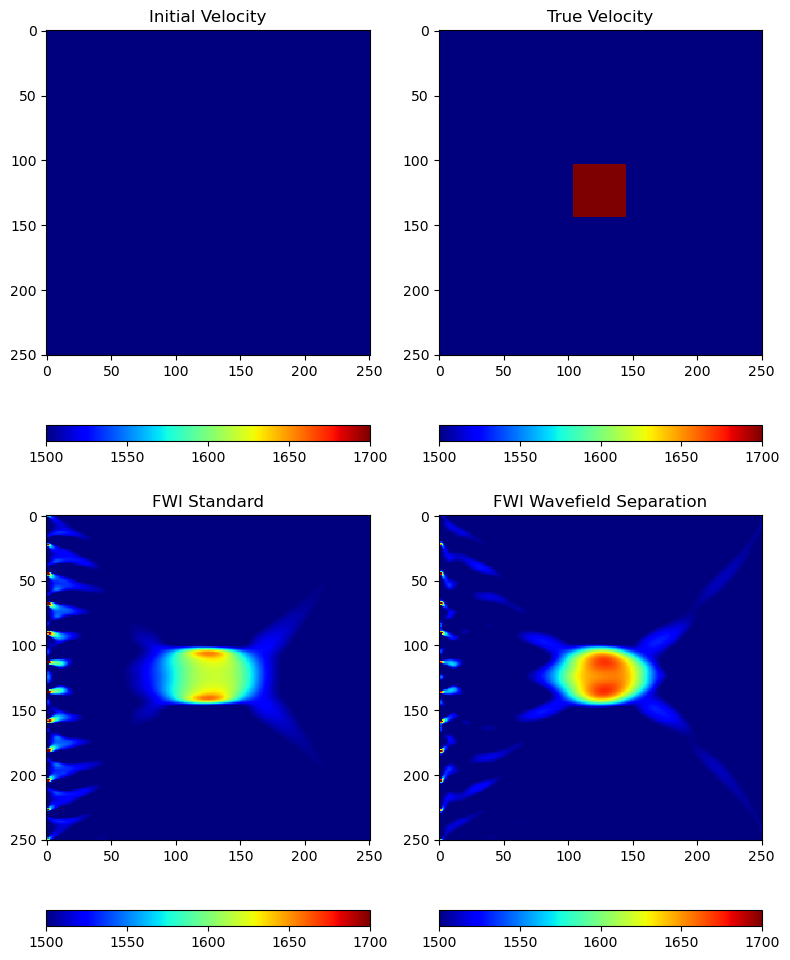

In [28]:
figure(figsize=(8,10)); clf()

subplot(2,2,1);imshow(v2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("Initial Velocity");

subplot(2,2,2);imshow(v1,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("True Velocity")

subplot(2,2,3);imshow(vf1,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("FWI Standard");

subplot(2,2,4);imshow(vf2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("FWI Wavefield Separation");

tight_layout()

#### Display the velocity differences 

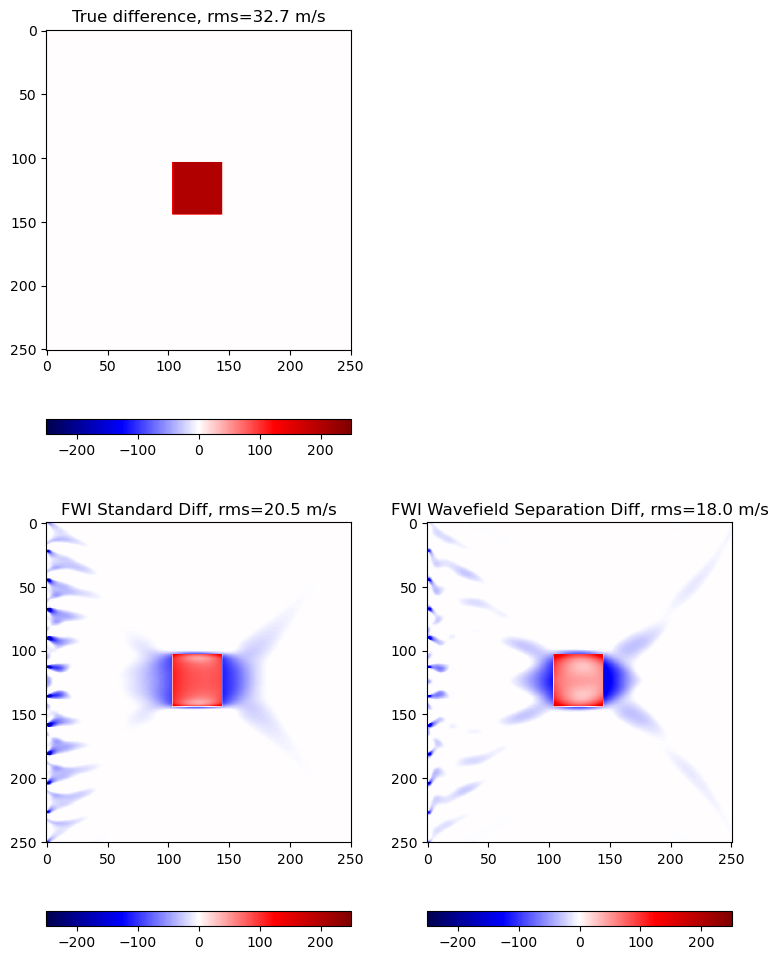

In [29]:
rms_v2  = @sprintf("%.1f m/s", sqrt(norm(v1 .- v2)^2 / length(v1)))
rms_vf1 = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf1)^2 / length(v1)))
rms_vf2 = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf2)^2 / length(v1)))

figure(figsize=(8,10)); clf()

subplot(2,2,1);imshow(v1 .- v2,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("True difference, rms=$(rms_v2)");

subplot(2,2,3);imshow(v1 .- vf1,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("FWI Standard Diff, rms=$(rms_vf1)");

subplot(2,2,4);imshow(v1 .- vf2,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("FWI Wavefield Separation Diff, rms=$(rms_vf2)");

tight_layout()

#### Display the cost function 

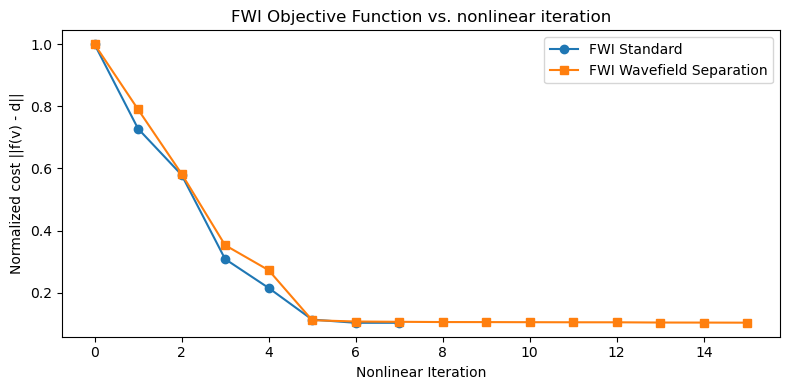

ϕ1[end] / ϕ1[1] = 0.10283137f0
ϕ2[end] / ϕ2[1] = 0.103195824f0
length(iters1) = 8


8

In [30]:
figure(figsize=(8,4)); clf()
iters1 = [0:length(ϕ1)-1;]
iters2 = [0:length(ϕ2)-1;]
plot(iters1, ϕ1 ./ ϕ1[1], marker="o", label="FWI Standard")
plot(iters2, ϕ2 ./ ϕ2[1], marker="s", label="FWI Wavefield Separation")
legend()
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title("FWI Objective Function vs. nonlinear iteration");
tight_layout()

@show ϕ1[end] / ϕ1[1]
@show ϕ2[end] / ϕ2[1]

@show length(iters1)

#### Display data misfit vs model misfit

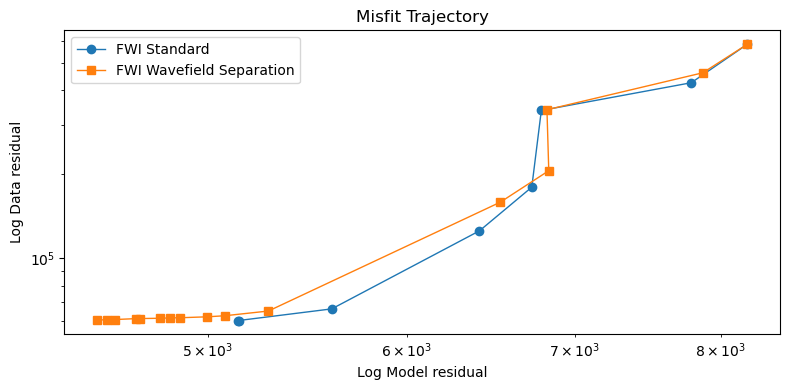

In [31]:
figure(figsize=(8,4)); clf()

c1 = [norm(m1[i] .- v1) for i in 1:length(m1)]
c2 = [norm(m2[i] .- v1) for i in 1:length(m2)]

loglog(c1, ϕ1, label="FWI Standard", marker="o", linewidth=1)
loglog(c2, ϕ2, label="FWI Wavefield Separation", marker="s", linewidth=1)
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory");
tight_layout()

## 11. Visualize data match
#### Generate data in the FWI velocity models

In [32]:
tf1 = @elapsed begin
    df1 = F1*vf1;
end
@show tf1;

tf2 = @elapsed begin
    df2 = F1*vf2;
end
@show tf2;

tf1 = 32.091235644
tf2 = 31.835466046


#### Compute residuals and collect gathers for display

In [33]:
rf1 = d1 .- df1;
rf2 = d1 .- df2;

df1local = [getblock(df1,i) for i in shots];
df2local = [getblock(df2,i) for i in shots];
rf1local = [getblock(rf1,i) for i in shots];
rf2local = [getblock(rf2,i) for i in shots];

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Standard</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Standard Residual</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Wavefield Separation</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Wavefield Separation Residual</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [34]:
function make_plot(index)
    figure(figsize=(8,9)); clf()
    catii = hcat(d1local[index],  pad, d2local[index],  pad, rlocal[index])
    catf1 = hcat(df1local[index], pad, df1local[index], pad, rf1local[index])
    catf2 = hcat(df2local[index], pad, df2local[index], pad, rf2local[index])

    subplot(3,1,1);
    imshow(catii,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sz=$(sz[index])   |   Initial sz=$(sz[index])   |   Initial Residual sz=$(sz[index])");
    
    subplot(3,1,2);
    imshow(catf1,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sz=$(sz[index])   |   FWI Standard sz=$(sz[index])   |   Initial Residual sz=$(sz[index])");
    
    subplot(3,1,3);
    imshow(catf2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sz=$(sz[index])   |   FWI Wavefield Separation sz=$(sz[index])   |   Initial Residual sz=$(sz[index])");
    
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

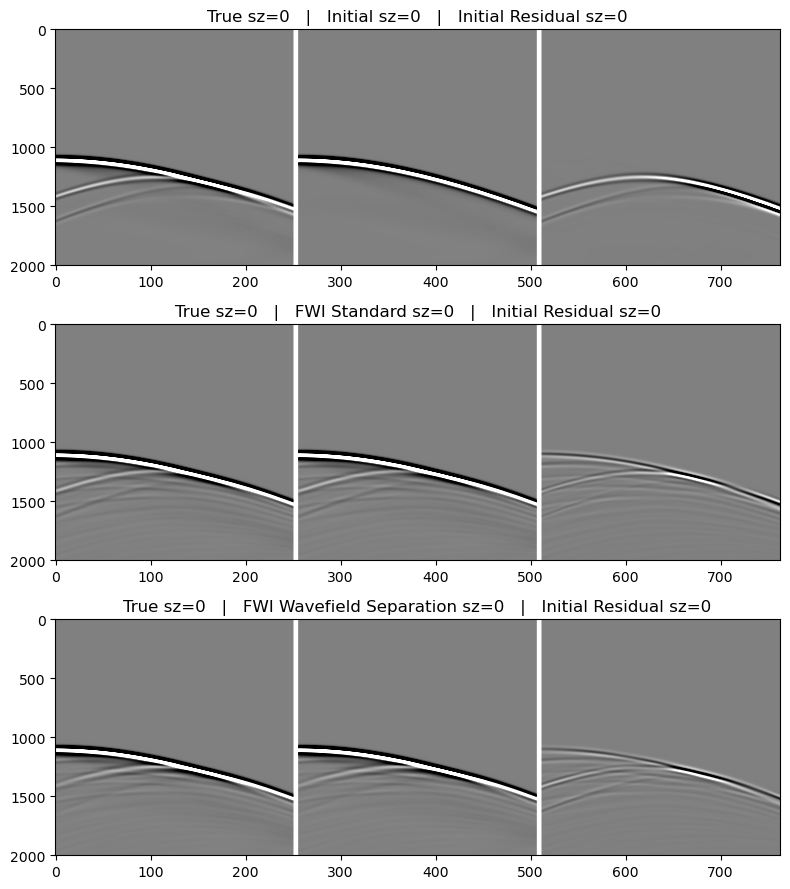

In [35]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

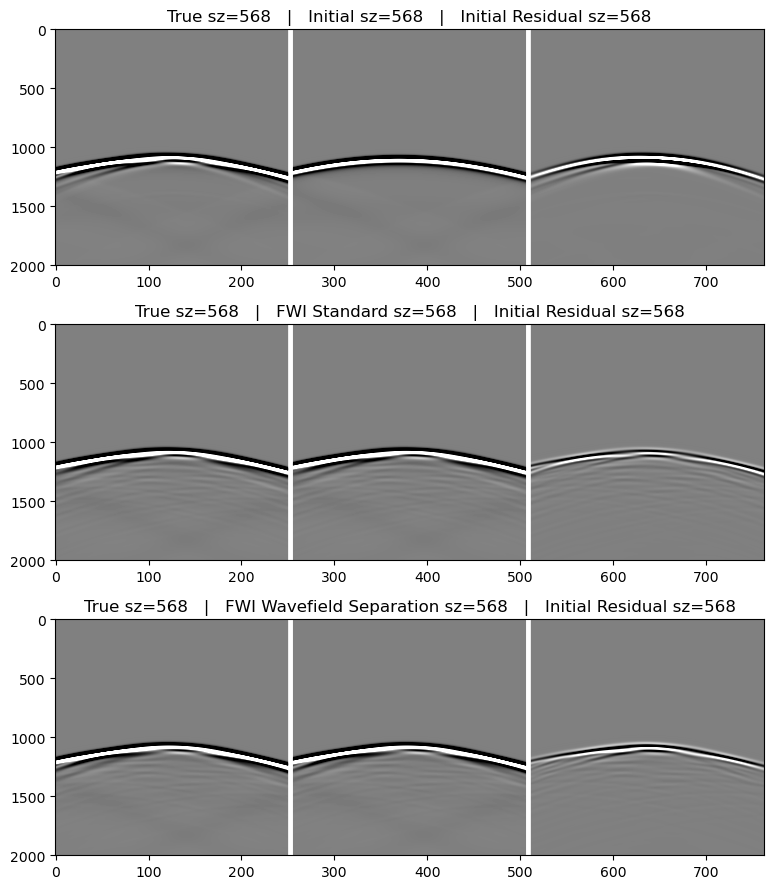

In [36]:
make_plot(2)

#### Data for the 8th shot, generated in the initial and FWI models

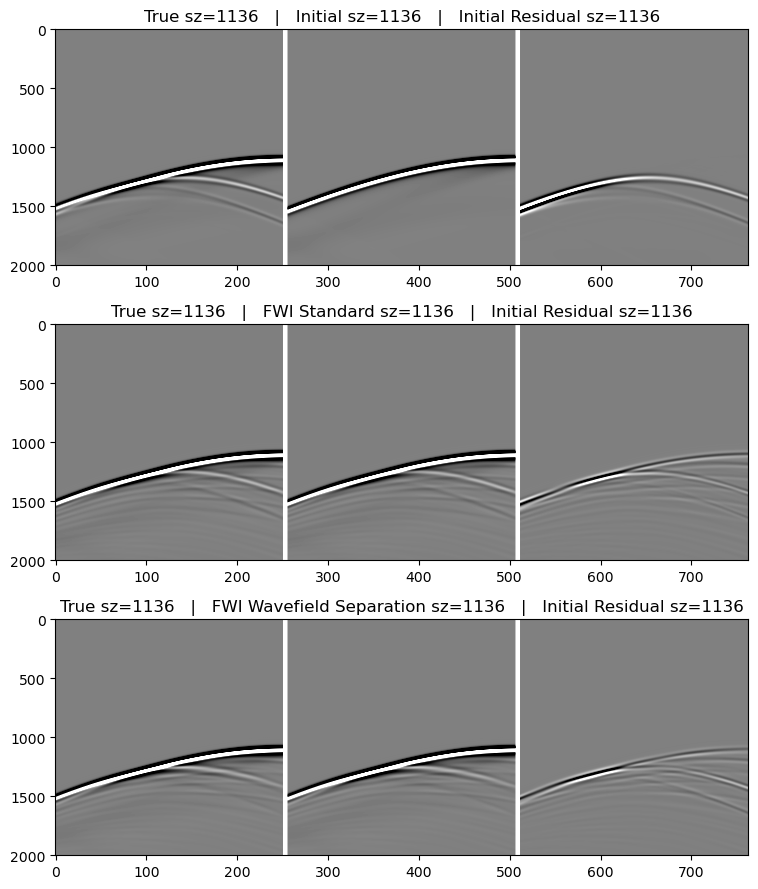

In [37]:
make_plot(3)

## 12. Remove local files and workers

In [38]:
# close(F);
# rmprocs(workers());

## Record time at end of notebook
Report total elapsed time to run the notebook

In [39]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 71.52 minutes\n"